In [2]:
import pandas as pd
from category_encoders import TargetEncoder

## 1. Load clean dataset

In [3]:
pd.set_option('display.max_columns', None)  # Show all columns when displaying DataFrames
pd.set_option('display.max_rows', 100)     # Show 100 rows when displaying DataFrames

In [4]:
train_df = pd.read_csv("/Users/leduongkhoa/Regression_MachineLearning_End2End/data/processed/cleaned_train.csv")
eval_df = pd.read_csv("/Users/leduongkhoa/Regression_MachineLearning_End2End/data/processed/cleaned_eval.csv")
holdout_df = pd.read_csv("/Users/leduongkhoa/Regression_MachineLearning_End2End/data/processed/cleaned_holdout.csv")

In [5]:
train_df['date'] = pd.to_datetime(train_df['date'])
eval_df['date'] = pd.to_datetime(eval_df['date'])
holdout_df['date'] = pd.to_datetime(holdout_df['date'])

# check date range of each dataset
print("Train date range:", train_df['date'].min(), "to", train_df['date'].max())
print("Eval date range:", eval_df['date'].min(), "to", eval_df['date'].max())
print("Holdout date range:", holdout_df['date'].min(), "to", holdout_df['date'].max())

Train date range: 2012-03-31 00:00:00 to 2019-12-31 00:00:00
Eval date range: 2020-01-31 00:00:00 to 2021-12-31 00:00:00
Holdout date range: 2022-01-31 00:00:00 to 2023-12-31 00:00:00


## Feature Engineering

### 1. Date features

In [6]:
def add_date_features(df):
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month

    # move date-related cols to the front
    cols_to_front = ['date', 'year', 'quarter', 'month']
    df = df[cols_to_front + [col for col in df.columns if col not in cols_to_front]]

    # df.insert(0, "date", df.pop("date"))
    # df.insert(1, "year", df.pop("year"))
    # df.insert(2, "quarter", df.pop("quarter"))
    # df.insert(3, "month", df.pop("month"))
    
    return df

train_df = add_date_features(train_df)
eval_df = add_date_features(eval_df)
holdout_df = add_date_features(holdout_df)

### 2. Freq encoding

In [8]:
zip_counts = train_df['zipcode'].value_counts()

train_df['zipcode_freq'] = train_df['zipcode'].map(zip_counts)
eval_df['zipcode_freq'] = eval_df['zipcode'].map(zip_counts).fillna(0)
holdout_df['zipcode_freq'] = holdout_df['zipcode'].map(zip_counts).fillna(0)

print(train_df[["zipcode", "zipcode_freq"]].head())

   zipcode  zipcode_freq
0    30002            94
1    15469            87
2    15468            89
3    15466            86
4    15464            86


### 3. Target Encoding

In [9]:
te = TargetEncoder(cols=['city_full'])

train_df['city_encoded'] = te.fit_transform(train_df['city_full'], train_df['price'])
eval_df['city_encoded'] = te.transform(eval_df['city_full'])
holdout_df['city_encoded'] = te.transform(holdout_df['city_full'])

print(train_df[["city_full", "city_encoded"]].head())

                       city_full   city_encoded
0  Atlanta-Sandy Springs-Roswell  192580.125925
1                     Pittsburgh  131539.870286
2                     Pittsburgh  131539.870286
3                     Pittsburgh  131539.870286
4                     Pittsburgh  131539.870286


### 4. Drop unused cols

In [10]:
unwanted_cols = ["date", "city_full", "city", "zipcode", "median_sale_price"]

train_df.drop(columns=unwanted_cols, inplace=True)
eval_df.drop(columns=unwanted_cols, inplace=True)
holdout_df.drop(columns=unwanted_cols, inplace=True)

### 5. Save feature engineered datasets

In [11]:
train_df.to_csv("/Users/leduongkhoa/Regression_MachineLearning_End2End/data/processed/encoded_train.csv", index=False)
eval_df.to_csv("/Users/leduongkhoa/Regression_MachineLearning_End2End/data/processed/encoded_eval.csv", index=False)
holdout_df.to_csv("/Users/leduongkhoa/Regression_MachineLearning_End2End/data/processed/encoded_holdout.csv", index=False)

# Multicolinearity

To check multicolinearity we can use:
* VIF
* Correlation matrix

In [12]:
df = train_df.copy()

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [16]:
def calculate_vif(df, target_cols=None):
    # Keep numeric cols only
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    
    # Drop targets cols if provided
    if target_cols:
        numeric_df = numeric_df.drop(columns=target_cols)

    # Add constant term for intercept
    X = add_constant(numeric_df)

    # Compute VTF for each feature and ingore the constant term
    vif_data = pd.DataFrame()
    vif_data['feature'] = numeric_df.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i + 1) for i in range(len(numeric_df.columns))]

    return vif_data.sort_values(by='VIF', ascending=False).reset_index(drop=True)

In [17]:
df = pd.read_csv("/Users/leduongkhoa/Regression_MachineLearning_End2End/data/processed/encoded_train.csv")
vif_df = calculate_vif(df, target_cols=['price'])
print(vif_df)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                         feature          VIF
0        Total School Enrollment          inf
1    Total School Age Population          inf
2               Total Population  6665.079139
3              Total Labor Force   837.634155
4            Median Commute Time   650.599476
5   Total Families Below Poverty   576.380733
6            Total Housing Units    21.116881
7                   new_listings    20.337904
8                        quarter    17.418659
9                          month    17.377459
10                    homes_sold    14.112241
11         Unemployed Population    12.883403
12                    restaurant    10.927654
13                          bank    10.676744
14                   supermarket     9.622881
15                 pending_sales     9.266207
16             Median Home Value     8.020372
17                     inventory     5.998705
18                        school     5.768663
19                          park     5.747502
20             Per Capita Income  

* IF > 10 → serious multicollinearity.

* VIF > 100 → catastrophic (drop/re-engineer immediately).

* VIF = ∞ → perfect linear redundancy (drop one).

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

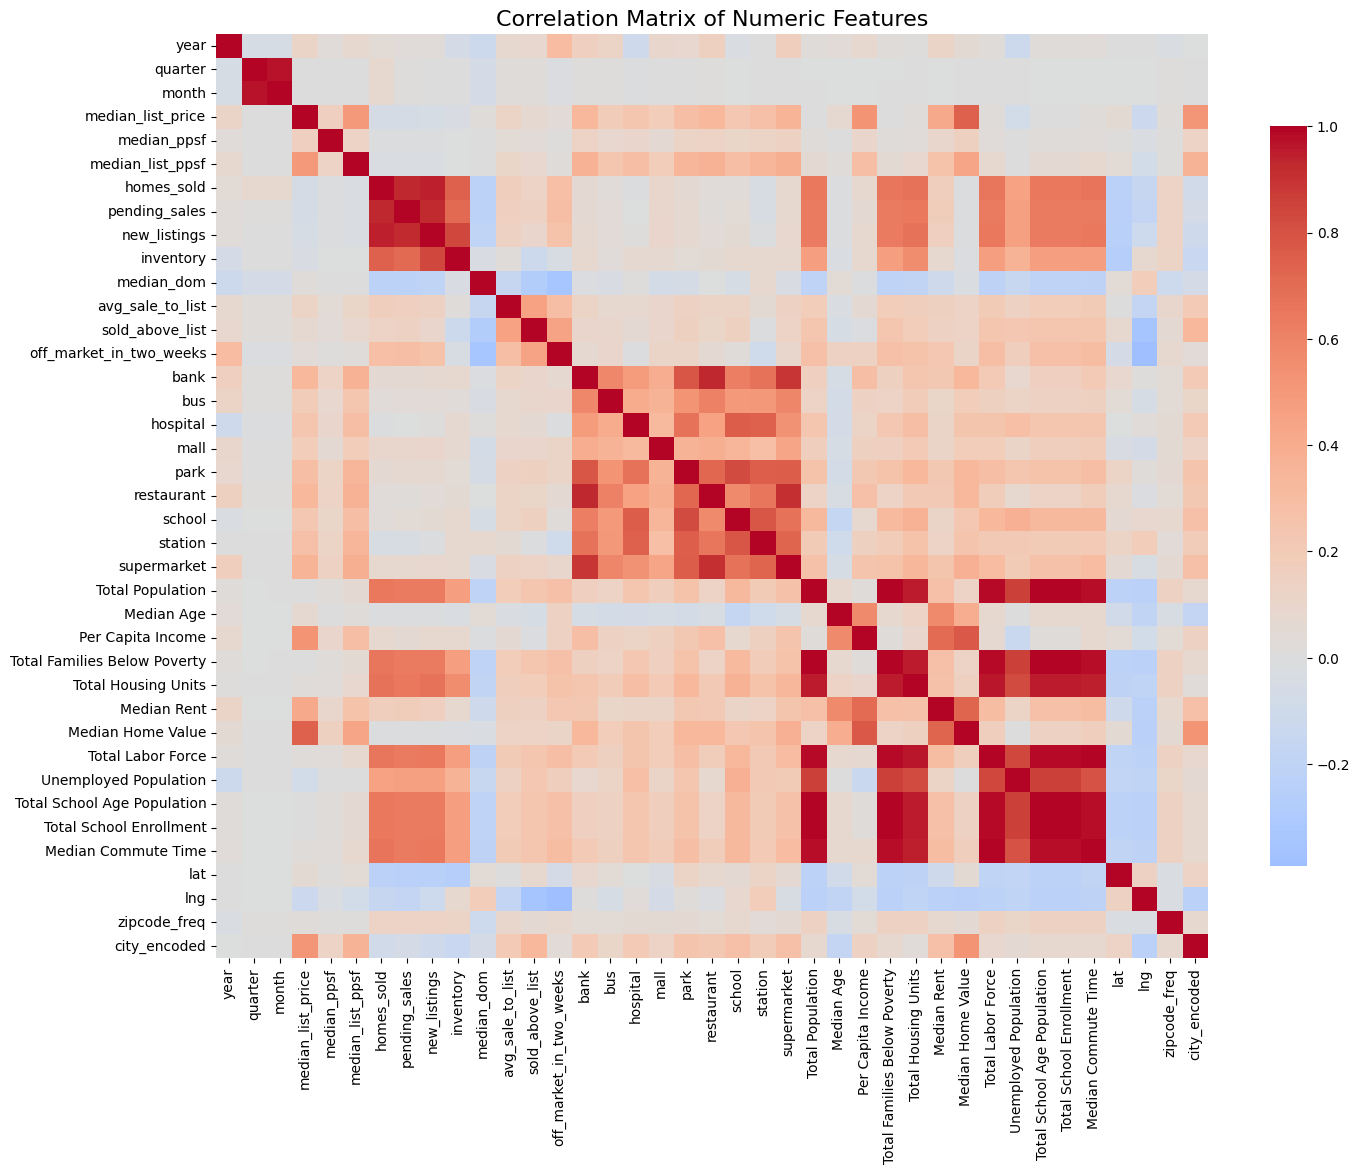

In [19]:
# Select only numeric features (exclude the target 'price')
numeric_df = df.select_dtypes(include=['float64', 'int64']).drop(columns=["price"], errors="ignore")

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Display full matrix as heatmap
plt.figure(figsize=(16,12))
sns.heatmap(
    corr_matrix, 
    cmap="coolwarm", 
    center=0, 
    annot=False,   # set to True if you want numbers on cells
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.show()

In [20]:
offenders = ["Total Population", "Total Labor Force", "Total Families Below Poverty"]
corr_matrix = df[offenders].corr()
print(corr_matrix)

                              Total Population  Total Labor Force  \
Total Population                      1.000000           0.985545   
Total Labor Force                     0.985545           1.000000   
Total Families Below Poverty          0.998984           0.985531   

                              Total Families Below Poverty  
Total Population                                  0.998984  
Total Labor Force                                 0.985531  
Total Families Below Poverty                      1.000000  


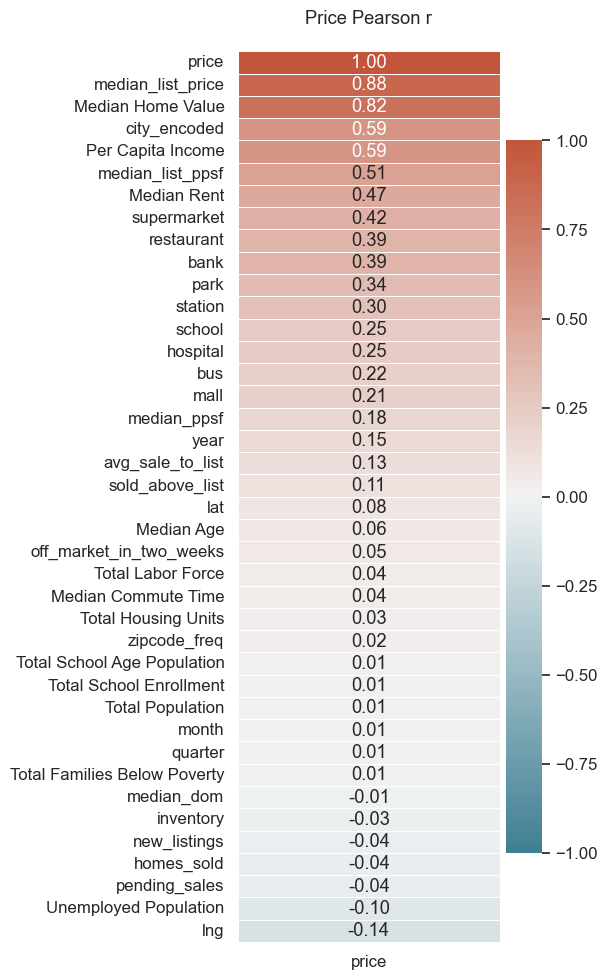

In [21]:
# Compute correlations with price
num_cols = df.select_dtypes("number").columns
corr_vec  = df[num_cols].corr(method="pearson")["price"].sort_values(ascending=False)
sns.set_theme(style="white")     
sns.set(font_scale=1.1)          
plt.figure(figsize=(6,10))       
ax = sns.heatmap(
        corr_vec.to_frame(),     
        annot=True, fmt=".2f",
        vmin=-1, vmax=1,         
        cmap=sns.diverging_palette(220, 20, as_cmap=True),
        center=0,
        linewidths=.5, linecolor="white",
        cbar_kws={"shrink":0.8, "pad":0.02}
     )
ax.set_title("Price Pearson r", pad=20)
ax.set_ylabel("")                 
ax.set_xlabel("")
plt.tight_layout()
plt.show()